In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import math
import matplotlib.dates as mdates
import datetime as dt 

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import * 
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from pandas.plotting import autocorrelation_plot

from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller

import yfinance as yf
from pandas_datareader import data

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

2022-11-02 16:48:52.793291: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tsla = yf.download('TSLA', start='2017-10-28', end='2022-10-28')
tsla


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-30,21.278667,21.585333,21.150000,21.338667,21.338667,63816000
2017-10-31,21.348667,22.129999,21.345333,22.101999,22.101999,85084500
2017-11-01,22.150000,22.174000,21.350668,21.405333,21.405333,126859500
2017-11-02,20.008667,20.579332,19.508667,19.950666,19.950666,296871000
2017-11-03,19.966667,20.416668,19.675333,20.406000,20.406000,133410000
...,...,...,...,...,...,...
2022-10-21,206.419998,214.660004,203.800003,214.440002,214.440002,75713800
2022-10-24,205.820007,213.500000,198.589996,211.250000,211.250000,100446800
2022-10-25,210.100006,224.350006,210.000000,222.419998,222.419998,96507900


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

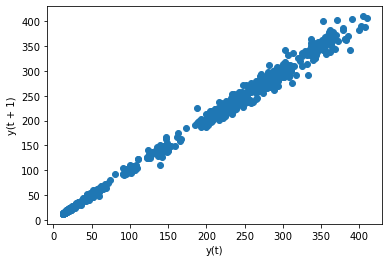

In [3]:
lag_plot(tsla.Close)

mean : 126.5030392296553


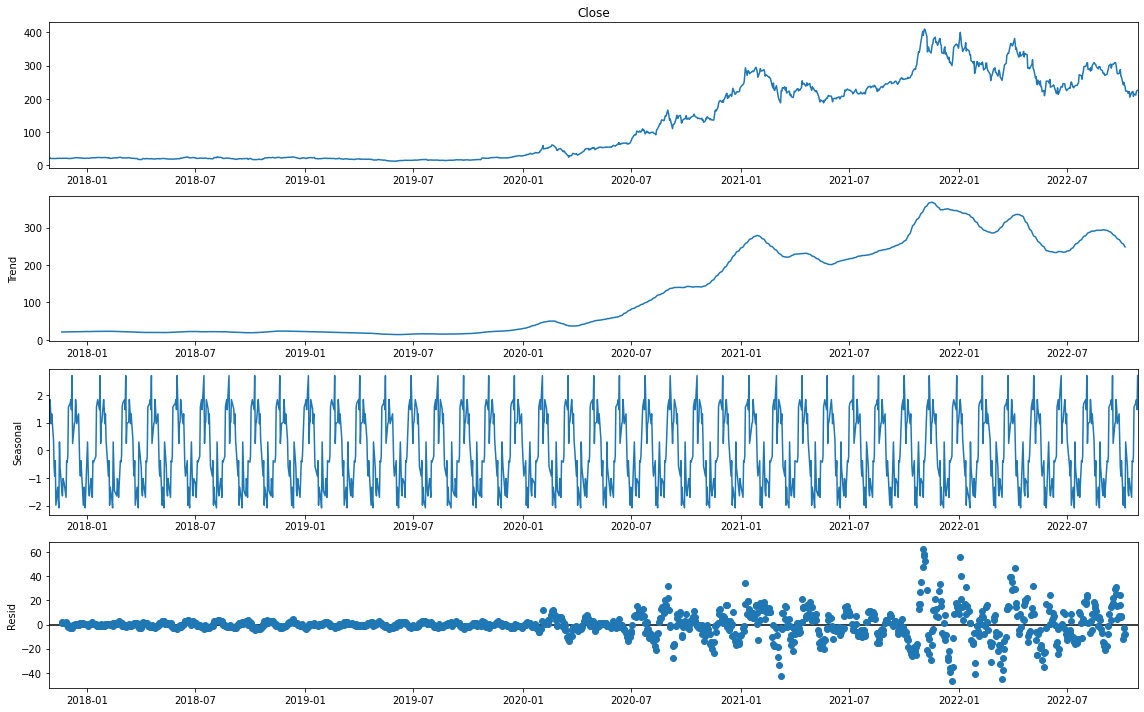

In [4]:
import statsmodels.api as sm
print('mean :' , tsla.Close.mean())
res = sm.tsa.seasonal_decompose(tsla.Close, period=30)
resplot = res.plot()
resplot.set_size_inches((16,10))
resplot.tight_layout()



<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

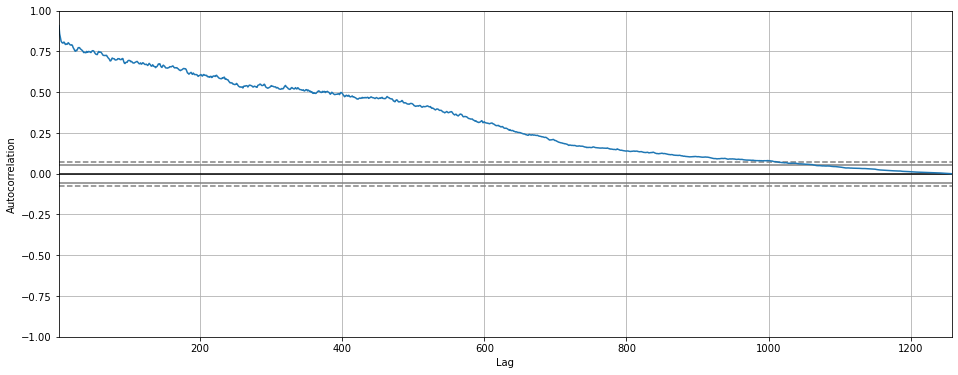

In [5]:
plt.figure(figsize=(16,6))
autocorrelation_plot(tsla)

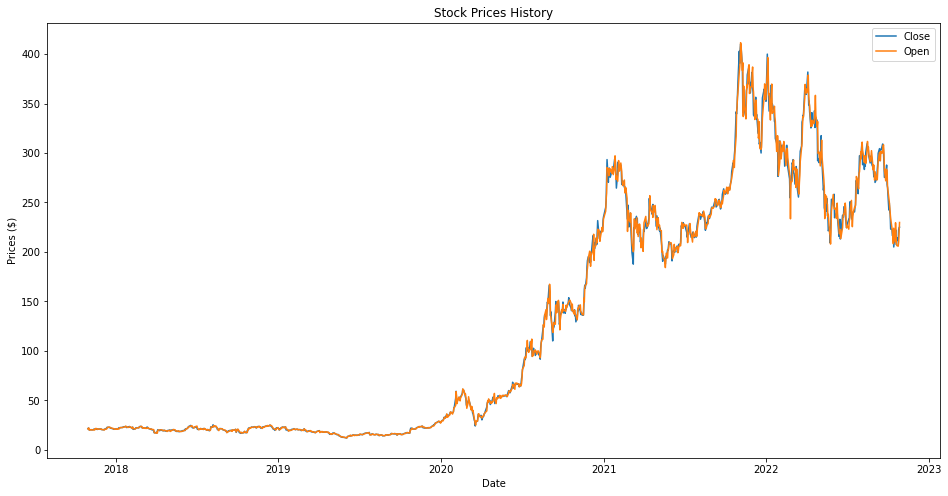

In [6]:
plt.figure(figsize=(16, 8))
plt.title('Stock Prices History')
plt.plot(tsla['Close'], label='Close')
plt.plot(tsla['Open'], label='Open')
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.legend()

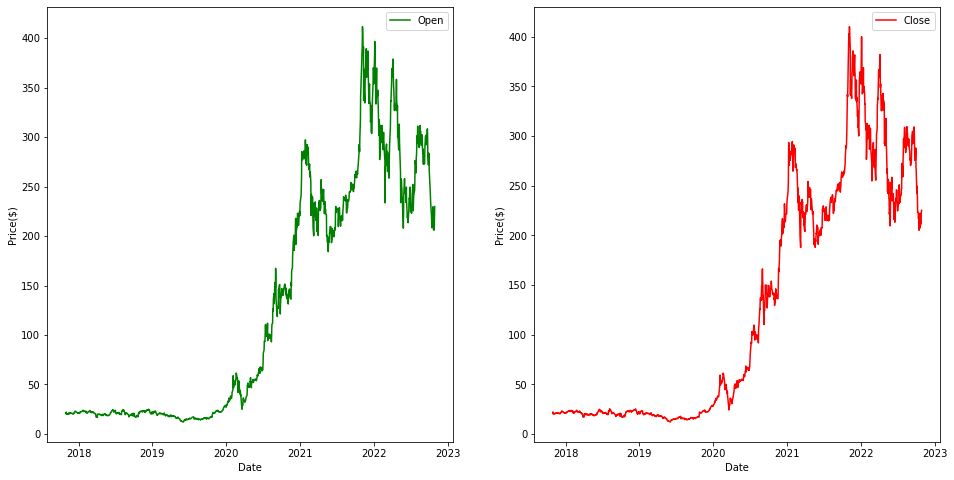

In [7]:
fg, ax =plt.subplots(1,2,figsize=(16,8))
ax[0].plot(tsla['Open'],label='Open',color='green')
ax[0].set_xlabel('Date',size=10)
ax[0].set_ylabel('Price($)',size=10)
ax[0].legend()
ax[1].plot(tsla['Close'],label='Close',color='red')
ax[1].set_xlabel('Date',size=10)
ax[1].set_ylabel('Price($)',size=10)
ax[1].legend()
plt.show()

In [8]:
close_prices = tsla['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(30, len(train_data)):
    x_train.append(train_data[i-30:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


test_data = scaled_data[training_data_len-30: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(30, len(test_data)):
    x_test.append(test_data[i-30:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [9]:
%%time
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1))) # return=True so the output of the layer will be another sequence of the same length
model.add(layers.LSTM(100, return_sequences=False)) # reture=false to only return the last output in the output sequence
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()



2022-11-02 16:49:13.019465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
CPU times: user 1 s, sys: 36.1 ms, total: 1.04 s
Wall time: 2.43 s


In [10]:
%%time
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 30, epochs=20)

Epoch 1/20
33/33 [==============================] - 20s 92ms/step - loss: 0.0099
Epoch 2/20
33/33 [==============================] - 3s 83ms/step - loss: 8.2605e-04
Epoch 3/20
33/33 [==============================] - 3s 82ms/step - loss: 6.1653e-04
Epoch 4/20
33/33 [==============================] - 3s 75ms/step - loss: 6.8773e-04
Epoch 5/20
33/33 [==============================] - 2s 73ms/step - loss: 7.0033e-04
Epoch 6/20
33/33 [==============================] - 3s 81ms/step - loss: 5.0255e-04
Epoch 7/20
33/33 [==============================] - 3s 83ms/step - loss: 5.1841e-04
Epoch 8/20
33/33 [==============================] - 2s 68ms/step - loss: 5.0023e-04
Epoch 9/20
33/33 [==============================] - 2s 72ms/step - loss: 5.2477e-04
Epoch 10/20
33/33 [==============================] - 2s 71ms/step - loss: 4.9929e-04
Epoch 11/20
33/33 [==============================] - 2s 64ms/step - loss: 4.5695e-04
Epoch 12/20
33/33 [==============================] - 2s 64ms/step - loss: 4.2

In [11]:
%%time
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

8/8 [==============================] - 2s 25ms/step
CPU times: user 1.44 s, sys: 207 ms, total: 1.65 s
Wall time: 1.64 s


4.227986005197958

<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


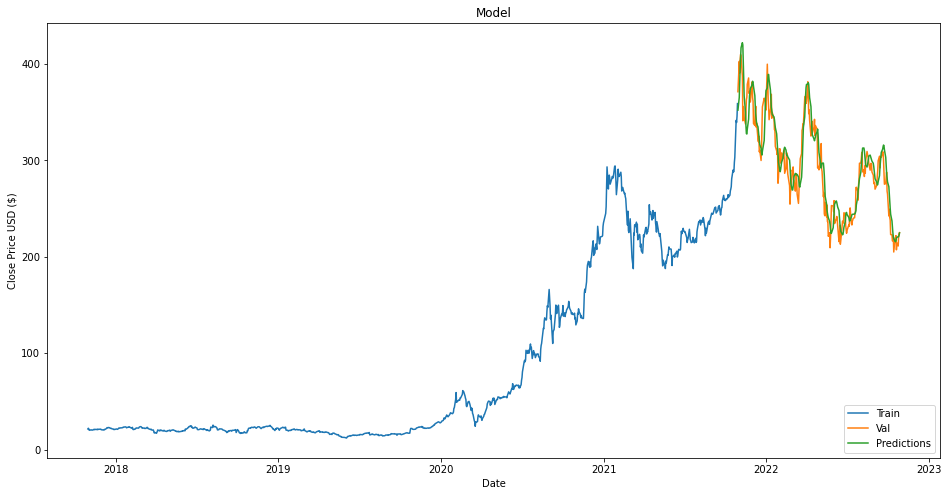

CPU times: user 791 ms, sys: 563 ms, total: 1.35 s
Wall time: 1.55 s


In [12]:
%%time
data = tsla.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

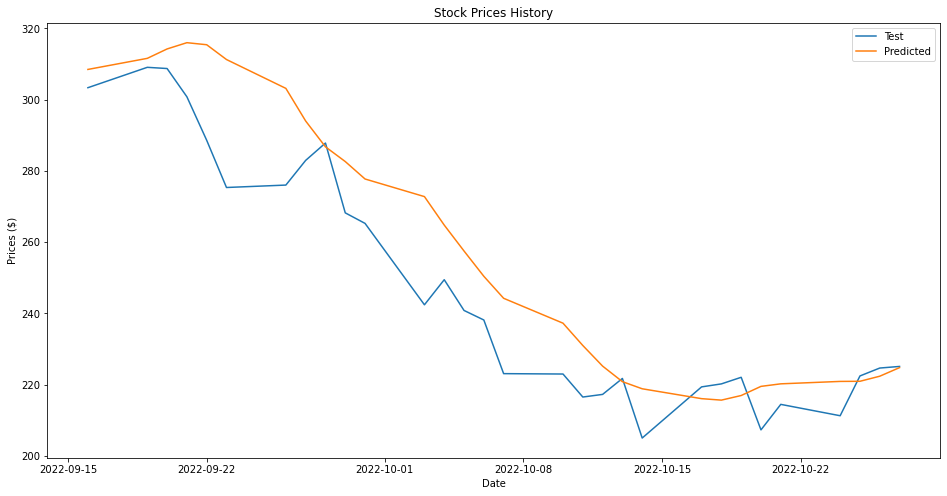

In [13]:
plt.figure(figsize=(16, 8))
plt.title('Stock Prices History')
plt.plot(validation['Close'].iloc[-30:], label='Test')
plt.plot(validation['Predictions'].iloc[-30:], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.legend()

# graphing just last 60 days of test vs predictions 

In [14]:
from pandas import Timestamp
start = Timestamp('2022-10-28')
end = Timestamp('2022-10-28')

all_dates = pd.date_range(start=start, end=end, freq='D')

# You can fill the "Value" column with any value you want. Here I filled with 0.
future = pd.DataFrame({'Date':all_dates , 'Value':[0]*len(all_dates)})
# future

future.index = pd.DatetimeIndex(future.Date, freq=None)
# future

future = future.drop(['Date'], axis=1)
future

,Value
Date,
2022-10-28,0


In [15]:
futurepredictions = model.predict(future)
futurepredictions = scaler.inverse_transform(futurepredictions)

1/1 [==============================] - 1s 1s/step


In [16]:
futurepredictions[0]

array([30.75513], dtype=float32)

In [17]:
# prediction a bit off but is the nature

In [18]:
tsla

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-10-30,21.278667,21.585333,21.150000,21.338667,21.338667,63816000
2017-10-31,21.348667,22.129999,21.345333,22.101999,22.101999,85084500
2017-11-01,22.150000,22.174000,21.350668,21.405333,21.405333,126859500
2017-11-02,20.008667,20.579332,19.508667,19.950666,19.950666,296871000
2017-11-03,19.966667,20.416668,19.675333,20.406000,20.406000,133410000
...,...,...,...,...,...,...
2022-10-21,206.419998,214.660004,203.800003,214.440002,214.440002,75713800
2022-10-24,205.820007,213.500000,198.589996,211.250000,211.250000,100446800
2022-10-25,210.100006,224.350006,210.000000,222.419998,222.419998,96507900


In [19]:
testtsla = tsla.iloc[-251:]

In [20]:
testtsla['predict'] = predictions

/var/folders/3k/_2nrg4_92wv7dq340pkrhc5h0000gn/T/ipykernel_85470/1829100473.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testtsla['predict'] = predictions


In [21]:
testtsla = testtsla[['Close', 'predict']]
testtsla

,Close,predict
Date,,
2021-10-29,371.333344,352.188354
2021-11-01,402.863342,365.417023
2021-11-02,390.666656,382.224823
2021-11-03,404.619995,395.846375
2021-11-04,409.970001,407.681946
...,...,...
2022-10-21,214.440002,220.206833
2022-10-24,211.250000,220.886383
2022-10-25,222.419998,220.922806


In [22]:
testtsla['diff'] = testtsla['predict'] - testtsla['Close']
testtsla

/var/folders/3k/_2nrg4_92wv7dq340pkrhc5h0000gn/T/ipykernel_85470/3238772081.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testtsla['diff'] = testtsla['predict'] - testtsla['Close']


,Close,predict,diff
Date,,,
2021-10-29,371.333344,352.188354,-19.144989
2021-11-01,402.863342,365.417023,-37.446320
2021-11-02,390.666656,382.224823,-8.441833
2021-11-03,404.619995,395.846375,-8.773621
2021-11-04,409.970001,407.681946,-2.288055
...,...,...,...
2022-10-21,214.440002,220.206833,5.766830
2022-10-24,211.250000,220.886383,9.636383
2022-10-25,222.419998,220.922806,-1.497192


In [23]:
testtsla.to_csv('tsla.csv', index=False)

In [27]:
# nflx.to_csv('nflxrealclose.csv', index=False)
tsla.to_csv('tslarealclose.csv', index=True)

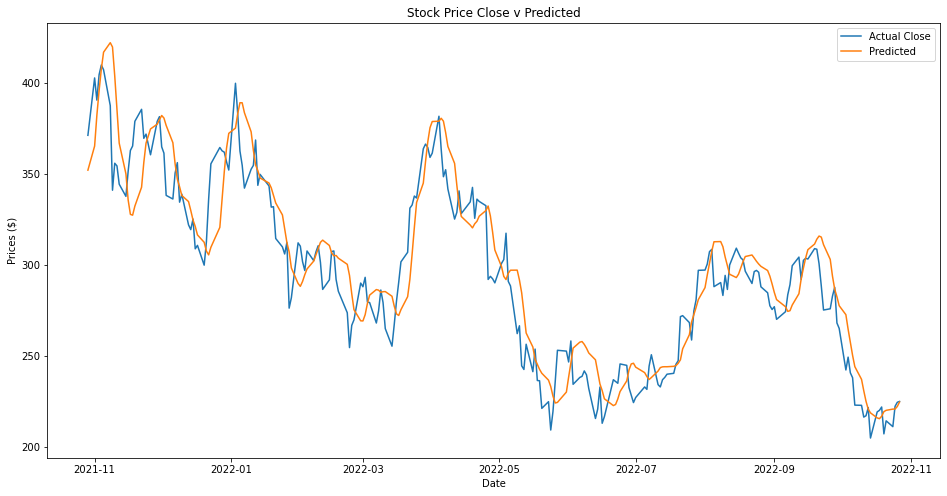

In [25]:
plt.figure(figsize=(16, 8))
plt.title('Stock Price Close v Predicted')
plt.plot(testtsla['Close'], label='Actual Close')
plt.plot(testtsla['predict'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Prices ($)')
plt.legend()